# Sistemas Operacionais
## Laboratório 01 - Gerência de processos

### **Introdução**
Neste laboratório aprenderemos a criar, excluir e modificar processos no Linux, utilizando a linguagem C. O foco desta aula será no aspecto prático do conteúdo, todavia um breve resumo da teoria será exposto, quando necessário, para auxiliar na execução dos exercícios.

Ao final desta aula, o estudante deverá ser capaz de:
* Usar as funções básicas do gerenciamento de processos no Linux;
* Entender as implicações da utilização da função `fork()`;
* Resolver problemas simples usando gerenciamento de processos.

###**Instruções**
Esse laboratório foi feito usando a ferramenta Colab do Google para evitar a necessidade de instalação de programas extras e máquinas virtuais. Para completá-lo, basta que o aluno siga os comandos em cada etapa e procure entender o que acontece com o sistema quando determinado código é executado. É recomendado também que o aluno tente introduzir pequenas modificações nos códigos fornecidos.

Na última parte desse material, há exercícios de programação, os quais o estudante deve realizar sozinho. Tais exercícios são fundamentais para testar a compreensão quanto ao conteúdo absorvido e aprofundar o conhecimento das funções expostas. As respostas para os exercícios serão apresentadas na próxima aula.


### **Parte 1 - Manipulando processos com as funções básicas**
Para um processo criar outro no Linux, usa-se a função `fork()`. Tal função retorna um inteiro do tipo pid_t (tipo reservado para identificadores de processos), de acordo com as condições abaixo:
* -1, caso haja erro na criação do novo processo;
* 0, para o processo filho;
* Um inteiro positivo representando o id do filho, para o processo pai.

Vejamos como isso acontece. Crie um arquivo C com o código abaixo ou o execute no Colab do Google.

In [1]:
%%writefile simpleFork.c
#include <sys/types.h>
#include <sys/wait.h>
#include <stdio.h>
#include <unistd.h>

int main(int argc, char **argv)
{
    pid_t pid=fork(); // Funcao usada para criar um novo processo

    if(pid<0){ // Erro na criacao do processo
		  printf("Sou o processo %d e nao consegui criar um novo processo.\n",getpid());
		  return 1;
    }else if (pid==0){ // Processo filho
		  printf("Sou o processo filho, meu PID e %d.\n",getpid());
	  }else{// Processo pai
		  printf("Sou o processo pai do %d, meu PID e %d.\n",pid,getpid());
      wait(NULL); // Funcao que faz o processo pai esperar pelo final da execucao de um de seus filhos
	  }

  return 0;
}

Writing simpleFork.c


Este código abaixo permite que você execute o arquivo aqui no Colab. Caso deseje executar no seu computador, remova o "!" e ajuste o caminho do arquivo.

In [2]:
!gcc ./simpleFork.c -o simpleFork
!./simpleFork

Sou o processo pai do 637, meu PID e 636.
Sou o processo filho, meu PID e 637.


A função `wait()` faz com que o pai espere pela execução do filho antes de continuar rodando. Chame essa função antes da linha `printf("Sou o processo pai do %d, meu PID e %d.\n",pid,getpid());` e perceba que o processo filho passa a escrever no terminal antes do processo pai.

Além disso, observe que o pai e o filho executam exatamente o mesmo código. Isso acontece pois, quando usamos a função `fork()`, o processo filho é uma cópia do processo pai.
Para alterarmos o programa que o filho está rodando, precisamos usar a função `exec()` ou uma de suas derivadas.

Faremos isso a seguir. Primeiro, criaremos um novo codigo para usar no processo filho. Neste código, faremos o filho imprimir uma frase no terminal.

In [3]:
%%writefile newProgram.c
#include <sys/types.h>
#include <sys/wait.h>
#include <stdio.h>
#include <unistd.h>

int main(int argc, char **argv)
{
  printf("Sou o processo %d e estou executando o meu proprio programa.\n",getpid());
  sleep(30); //Função que faz o programa dormir durante 30 segundos
}

Writing newProgram.c


In [4]:
!gcc ./newProgram.c -o newProgram

Depois, executaremos uma versao modificada do codigo *simpleFork* na qual passaremos esse novo programa para o processo filho.

In [5]:
%%writefile forkWithExec.c
#include <sys/types.h>
#include <sys/wait.h>
#include <stdio.h>
#include <unistd.h>

int main(int argc, char **argv)
{
    pid_t pid=fork(); // Funcao usada para criar um novo processo

    if(pid<0){ // Erro na criacao do processo
		  printf("Sou o processo %d e nao consegui criar um novo processo.\n",getpid());
		  return 1;
    }else if (pid==0){ // Processo filho
			execlp("./newProgram","np",NULL); // Funcao derivada da exec()
		  printf("Sou o processo filho, meu PID e %d.\n",getpid());
	  }else{// Processo pai
			wait(NULL); // Funcao que faz o processo pai esperar pelo final da execucao de um de seus filhos
		  printf("Sou o processo pai do %d, meu PID e %d.\n",pid,getpid());

		}

  return 0;
}

Writing forkWithExec.c


In [6]:
!gcc ./forkWithExec.c -o forkWithExec
!./forkWithExec

Sou o processo 909 e estou executando o meu proprio programa.
Sou o processo pai do 909, meu PID e 908.


Perceba que o processo filho não executou a linha após o `execlp()`, pois já estava executando o seu novo programa. Outrossim, veja que o processo pai aguardou os 30 segundos nos quais o filho estava "dormindo" antes de terminar a sua execução.

Caso esteja fazendo esse exercício fora do Colab, rode o programa *forkWithExec* novamente e digite o comando `top` no terminal antes que o processo filho acabe a sua execução. Se necessário, ajuste o *newProgram* para que o processo filho passe mais tempo dormindo. Conseguiu ver ambos os processo na lista gerada pelo `top`?

### **Parte 2 - Lidando com múltiplos forks**
Vimos que o processo filho executa o mesmo programa do pai, a menos que a função `exec()` seja chamada. O que acontece, então, quando há múltiplos `fork()` e nenhum outro programa é passado para os processos filhos?

Veremos essa resposta ao executar o código a seguir.

In [ ]:
%%writefile threeForks.c
#include <sys/types.h>
#include <sys/wait.h>
#include <stdio.h>
#include <unistd.h>

int main(int argc, char **argv)
{
    fork(); // Funcao usada para criar um novo processo
    fork(); // E mais um
    fork(); // E mais um
    printf("Sou o processo %d.\n",getpid());
    return 0;
}

Writing threeForks.c


In [ ]:
!gcc ./threeForks.c -o threeForks
!./threeForks

Sou o processo 55886.
Sou o processo 55888.
Sou o processo 55887.
Sou o processo 55892.
Sou o processo 55891.
Sou o processo 55893.
Sou o processo 55889.
Sou o processo 55890.


Perceba que temos 8 processos diferentes. Acompanhe o passo-a-passo do que aconteceu:
* No início, havia apenas o processo P0;
* Com o primeiro *fork()*, P0 cria P1;
* Com o segundo *fork()*, P0 e P1 criam P2 e P3, respectivamente;
* Com o terceiro e último *fork()*, P0, P1, P2 e P3 criam P4, P5, P6 e P7, respectivamente.
Tal passo-a-passo é mostrado na imagem abaixo.

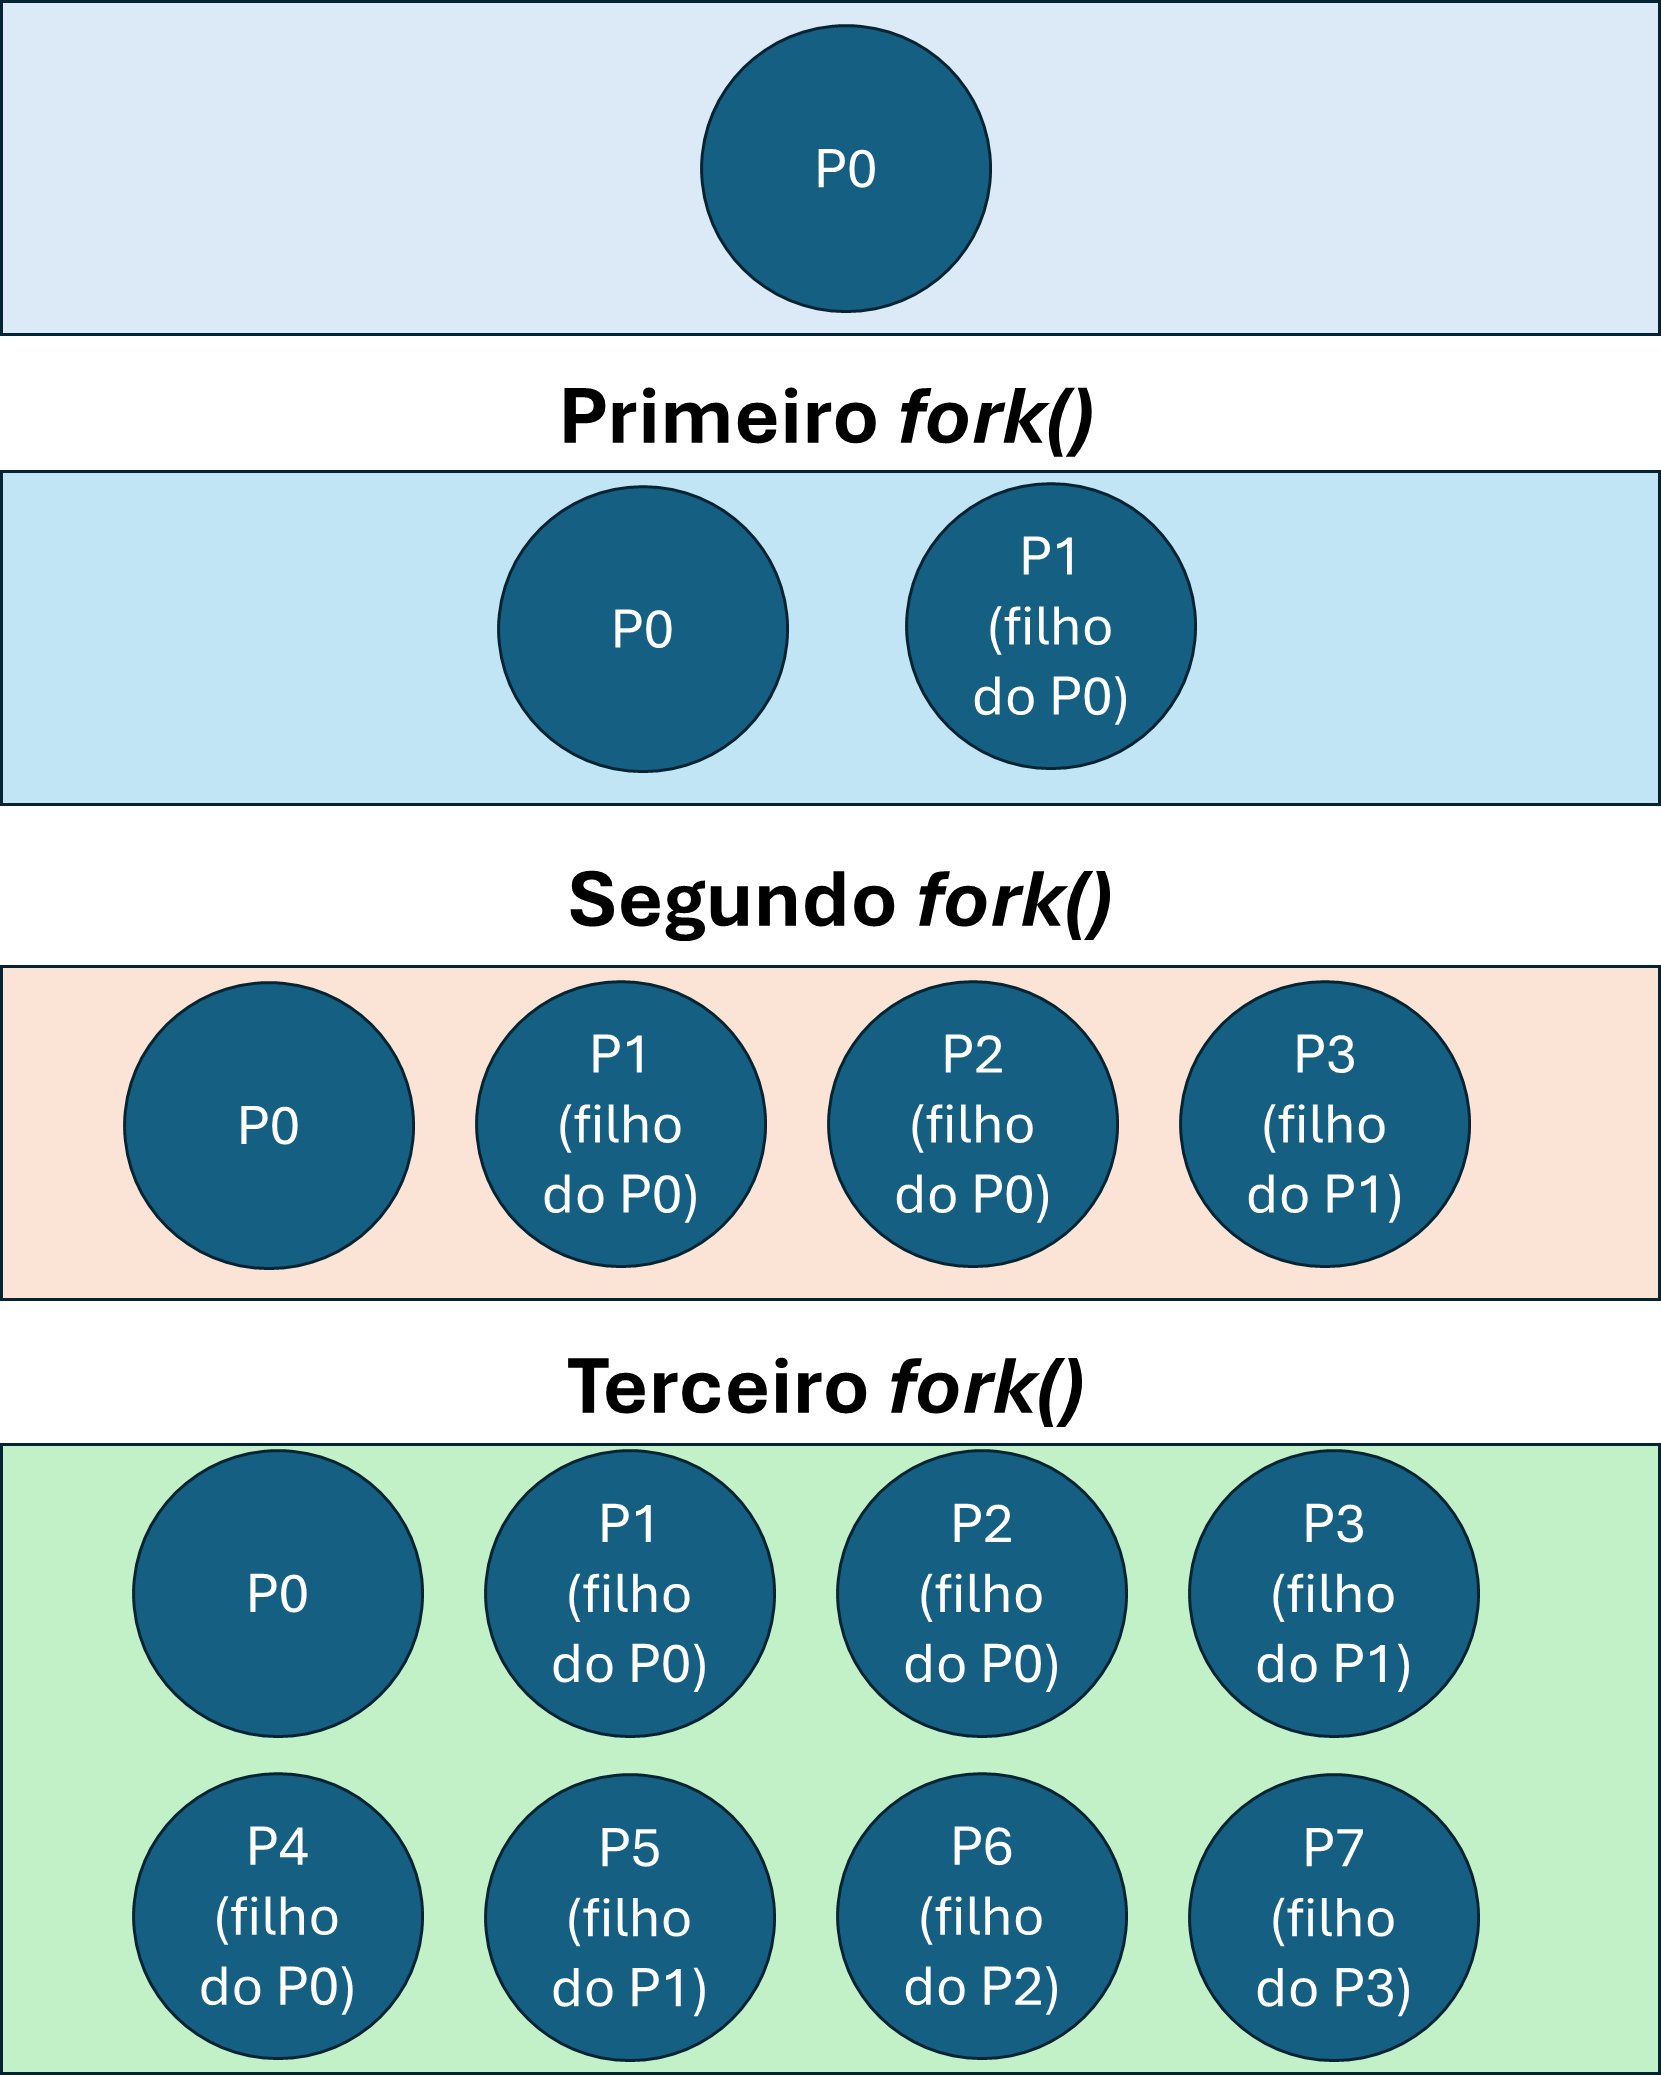

Por meio desse passo-a-passo, percebemos também que o processo criado continua a execução no mesmo ponto onde o pai está, e não do início do código.

Outra dúvida que pode surgir é a seguinte: quando todos os processos manipulam uma mesma variável, o que acontece?

In [10]:
%%writefile twoProcessesOneVariable.c
#include <sys/types.h>
#include <sys/wait.h>
#include <stdio.h>
#include <unistd.h>
#include <stdlib.h>

int valor=100;
int main(int argc, char **argv)
{
    pid_t pid=fork(); // Funcao usada para criar um novo processo
    if(pid==0){// Processo filho
      valor+=100;
      exit(0); // Funcao que encerra o processo
    }else if(pid>0){ // Processo pai
      wait(NULL); // O pai vai esperar a conclusao do filho
    }
    printf("Valor da variável e %d\n",valor);
    return 0;
}

Overwriting twoProcessesOneVariable.c


In [11]:
!gcc ./twoProcessesOneVariable.c -o twoProcessesOneVariable
!./twoProcessesOneVariable

Valor da variável e 100


Perceba que o único processo que realiza a impressão de *valor* é o processo pai, pois o filho já foi encerrado com a função *exit()*. Observe também que a variável permaneceu inalterada no processo pai, apesar do filho tê-la incrementado. Isso aconteceu pois, quando o filho foi criado, ele copiou a variável. Dessa maneira, ao fazer a operação `valor+=100;`, ele alterou apenas a sua própria cópia e não a variável presente no espaço de endereçamento do pai.

###Parte 3 - Exercícios

**Exercício 1**

Sabendo que a função `wait()` faz o processo pai esperar até que um dos seus filhos (o mais rápido) termine a sua execução e que ela retorna o PID do filho que terminou, crie um código no qual um pai espera **todos os seus filhos** terminarem, após a utilização de 4 comandos `fork()` **consecutivos**. Perceba que, nesse caso, há mais de um pai no programa.

**Exercício 2**

Com o código *twoProcessesOneVariable.c*, faça com que o filho receba a referência do parâmeto *valor*, não o parâmetro em si. Qual o resultado da variável em ambos os processos?

**Exercício 3**

Refaça o código acima usando 2 comandos `fork()` e 2 incrementações da variável *valor*, com o segundo `fork()` ocorrendo somente depois da primeira incrementação e apenas para o segundo processo. Ao final da execução, imprima o valor da variável para cada processo.

**Desafio**

Crie um programa que escreva a [sequência de Fibonacci](https://pt.wikipedia.org/wiki/Sequ%C3%AAncia_de_Fibonacci) em um processo filho, com o parâmetro *n* sendo variável.

**A primeira pessoa a enviar os códigos propostos por esses desafios para o e-mail tarciana.guerra@imd.ufrn.br ganha meio ponto extra.**